# UK Covid Analysis
### Date: 2021-02-01
### Author: Matt McDonnell @mattmcd

We can use the [UK Coronavirus Dashboard](https://coronavirus.data.gov.uk/details/developers-guide) [SDK](https://publichealthengland.github.io/coronavirus-dashboard-api-python-sdk/index.html) to perform a range of analyses.  Start with determining the lag between hospital admissions and deaths.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc3 as pm

In [2]:
%matplotlib inline

In [3]:
from uk_covid19 import Cov19API

In [4]:
overview_filter = [
    "areaType=overview"
]

admissions_and_deaths = {
    "date": "date",
    "areaName": "areaName",
    "areaCode": "areaCode",
    "newCasesBySpecimenDate": "newCasesBySpecimenDate",
    "newAdmissions": "newAdmissions",
    "newDeaths28DaysByDeathDate": "newDeaths28DaysByDeathDate",
    "newDeaths28DaysByPublishDate": "newDeaths28DaysByPublishDate"
}

api = Cov19API(
    filters=overview_filter,
    structure=admissions_and_deaths
)

df = api.get_dataframe()

In [5]:
# ETL: convert date to format and sort in order of increasing date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

print(df.head())

          date        areaName   areaCode  newCasesBySpecimenDate  \
407 2020-01-03  United Kingdom  K02000001                     NaN   
406 2020-01-04  United Kingdom  K02000001                     NaN   
405 2020-01-05  United Kingdom  K02000001                     NaN   
404 2020-01-06  United Kingdom  K02000001                     NaN   
403 2020-01-07  United Kingdom  K02000001                     NaN   

     newAdmissions  newDeaths28DaysByDeathDate  newDeaths28DaysByPublishDate  
407            NaN                         NaN                             0  
406            NaN                         NaN                             0  
405            NaN                         NaN                             0  
404            NaN                         NaN                             0  
403            NaN                         NaN                             0  


In [6]:
len(df)

408

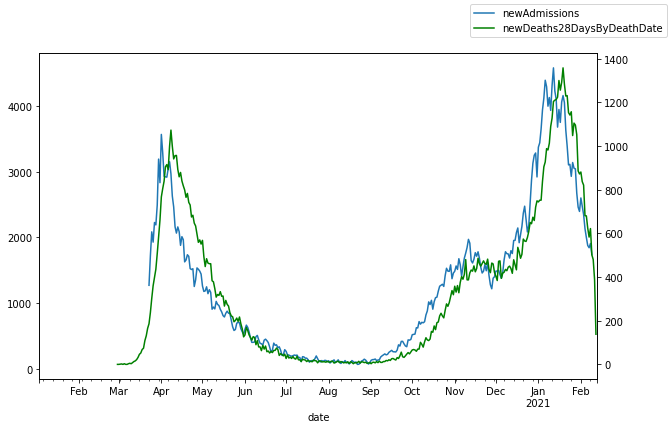

In [7]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
_ = df.plot(x='date', y='newAdmissions', ax=ax, legend=False)
ax2 = ax.twinx()
_ = df.plot(x='date', y='newDeaths28DaysByDeathDate', ax=ax2, c='g', legend=False)
_ = ax.figure.legend()

-0.94, -0.95, -0.96, -0.97, -0.97, -0.98, -0.98, -0.98, -0.98, -0.97, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92, -0.91, -0.90, -0.88, -0.87, 

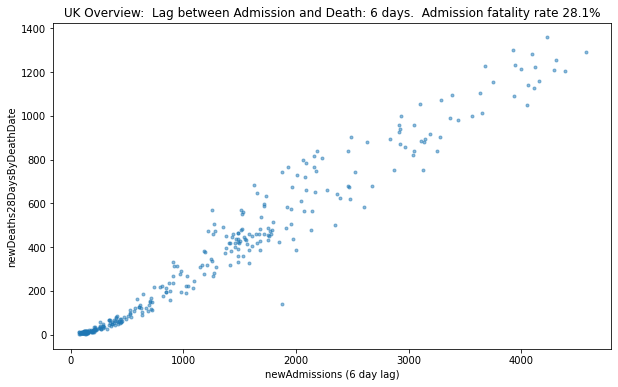

In [8]:
fig = plt.figure(figsize=(10,6))
# Simple linear fit, no intercept 
best_lag = 0
best_err = np.inf
scale = df['newAdmissions'].sum() / df['newDeaths28DaysByDeathDate'].sum()
for lag in range(0, 20):
#     err = np.mean((df['newAdmissions'].shift(lag) - scale*df['newDeaths28DaysByDeathDate'])**2)
    # Replace MSE error with correlation
    err = -df['newAdmissions'].shift(lag).corr(df['newDeaths28DaysByDeathDate'])
    print(f'{err:0.2f}', end=', ')
    if err < best_err:
        best_err = err
        best_lag = lag
    
_ = plt.plot(
    df['newAdmissions'].shift(best_lag), 
    df['newDeaths28DaysByDeathDate'], linestyle='none', marker='.', alpha=0.5)
_ = plt.title(
    f'UK Overview:  Lag between Admission and Death: {best_lag} days.  Admission fatality rate {100/scale:0.01f}%')
_ = plt.xlabel(f'newAdmissions ({best_lag} day lag)')
_ = plt.ylabel(f'newDeaths28DaysByDeathDate')
fig.savefig('uk_covid19_lag_analysis_20210201_death_vs_admission.png')

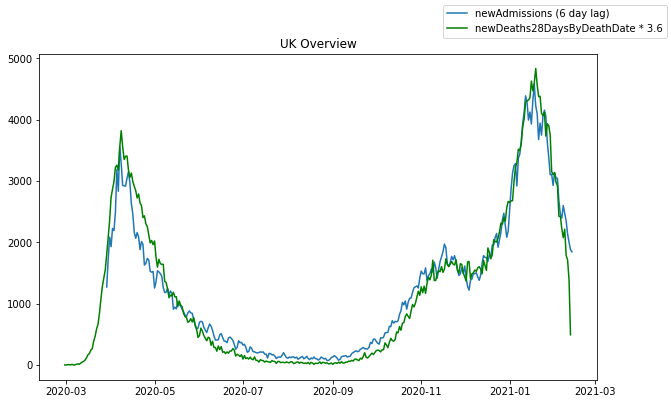

In [9]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
_ = plt.plot(df['date'], df['newAdmissions'].shift(best_lag))
# ax2 = ax.twinx()
_ = plt.plot(df['date'], df['newDeaths28DaysByDeathDate']*scale, c='g')
_ = fig.legend([f'newAdmissions ({best_lag} day lag)', f'newDeaths28DaysByDeathDate * {scale:0.01f}'])
_ = plt.title('UK Overview')
fig.savefig('uk_covid19_lag_analysis_20210201_death_vs_date.png')

# Cross correlation between signals
Try using some of the built in functionality from scipy and other libraries to find lag between the time series.

In [10]:
from scipy import signal

In [11]:
df_na = df.dropna()
corr = signal.correlate(df_na['newAdmissions'], df_na['newDeaths28DaysByDeathDate'])
lags = signal.correlation_lags(len(df_na['newDeaths28DaysByDeathDate']), len(df_na['newAdmissions']))

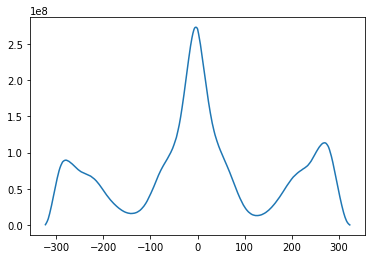

In [12]:
plt.plot(lags, corr)

In [13]:
lags[np.argmax(corr)]

-4

(need to play with this a bit more)